# Classification of Tweets
This notebook will explore 7631 which have been hand classified into those about real disasters (target class 1) and those which aren't (target class 0). 

Source :https://www.kaggle.com/competitions/nlp-getting-started/overview


## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#cleaning text
import re
import unidecode
from nltk.stem import PorterStemmer, WordNetLemmatizer
import emoji
import contractions
from textblob import TextBlob
from spellchecker import SpellChecker
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


#named entity recognition
import spacy
import en_core_web_sm

#wordcloud 
from collections import Counter
from wordcloud import WordCloud

#tokenizing 
from nltk.tokenize import TweetTokenizer

#import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
import plotly.express as px
import plotly.graph_objs as go

## 2. Loading Data and Initial Exploration

In [2]:
data = pd.read_csv('train.csv')
data.head(2)

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   

   target  
0       1  
1       1

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
data.shape

(7613, 5)

In [5]:
data.describe()

id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000

#### Comments
Note that the id values aren't in chronological order, so they aren't useful so we can probably just drop these. We do have missing keywords, and a lot more missing location entries. Having a look at the summary table, it's not insightful, so let's instead have a look at the data when we group it by the two different target classes. We do need to make sure the current data is shuffled too, as at the moment it looks like the first few entries are all disaster tweets. This could be a complete coincidence, but definitely worth checking. 

### Target Classes
Before moving onto looking at features, let's have a look at the balance of two target classes. 

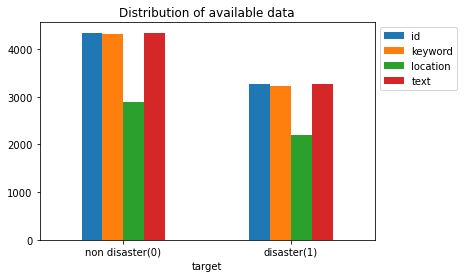

In [6]:
ax = data.groupby('target').count().plot(kind='bar', 
                                       title='Distribution of Data', 
                                      legend=True)
ax.set_xticklabels(['non disaster(0)', 'disaster(1)'], rotation=0)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Distribution of available data')
plt.savefig('Distibution_of_data.png', bbox_inches = 'tight')
plt.show();


In [7]:
print('Distribution of available data')
data.groupby('target').count()

Distribution of available data


id  keyword  location  text
target                               
0       4342     4323      2884  4342
1       3271     3229      2196  3271

### Missing Data

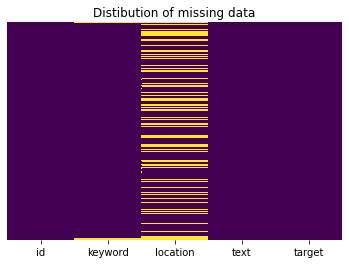

In [8]:
missing_data = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
missing_data = plt.title('Distibution of missing data')
plt.savefig('Distibution_of_missingdata.png', bbox_inches = 'tight')
missing_data = plt.show()

In [9]:
print('Percentage of missing data')
(data.isna().sum()/len(data))*100

Percentage of missing data


id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

#### Comments
We do have an imbalanced dataset, favouring tweets not associated with disasters more than those of disasters. Over 33% of the location data is missing, so this could potentially be dropped. An advantage is there are no missing data for text nor target values. Furthermore, less than 1% of the data is missing for keyword. Let's first get a better picture of the distribution of missing data, and then explore how to we should process the text and keyword data. Roughly the same proportion of data is missing from the disaster class as non disterous classes. This could mean we may not find any meaningful insights from identifying what data is missing. Let's see if we can break down the keywords and location data further. 

## 3. Data Wrangling 

### 3.1 Keyword and Location
The goal is to explore the keywords and location to determine if these would be useful features we can use for the classification model. If they are determined to be usefull, we can merge them into the tweets to use for further analysis, otherwise we'll drop these. 

#### 3.1.1 Keywords

In [10]:
keywords = data.drop(['location', 'text', 'id'], axis = 1)
keywords.shape

(7613, 2)

As we have seen the distibution of missing data is proportional, let's instead look at the keywords thre are are and see if we can observe anything meaningful.  

In [11]:
keywords = keywords.dropna()

In [12]:
print(keywords.nunique())

keyword    221
target       2
dtype: int64


In [13]:
keywords.shape

(7552, 2)

There are 221 unique keywords out of 7552 entries. We want to see if these 221 keywords can be used to classifiy the two different classes of if there is an overlap between their uses.

Before doing so, let's clean up the tweets so we can get rid of unwanted punctuation. Furthermore, we might have spelling errors which needs to be fixed and we might benefit from stemming in case same words of different tenses are used by different users. 

In [14]:
#lets clean the keywords so it omits %20, any accents and punctuation
def clean_keywords(keyword):
    cleaned = re.sub(r'%20', ' ', keyword)
    return cleaned
def remove_accents(keyword):
    cleaned = unidecode.unidecode(keyword)
    return cleaned
def remove_punctuation(keyword):
    cleaned = re.sub(r"[!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n -' ]"," ",keyword)
    return cleaned
keywords['keyword'] = keywords['keyword'].apply(lambda x: clean_keywords(x))
keywords['keyword'] = keywords['keyword'].apply(lambda x: remove_accents(x))
keywords['keyword'] = keywords['keyword'].apply(lambda x: remove_punctuation(x))

In [15]:
stemmer = PorterStemmer()
keywords['stems'] = keywords['keyword'].apply(lambda x: stemmer.stem(x))

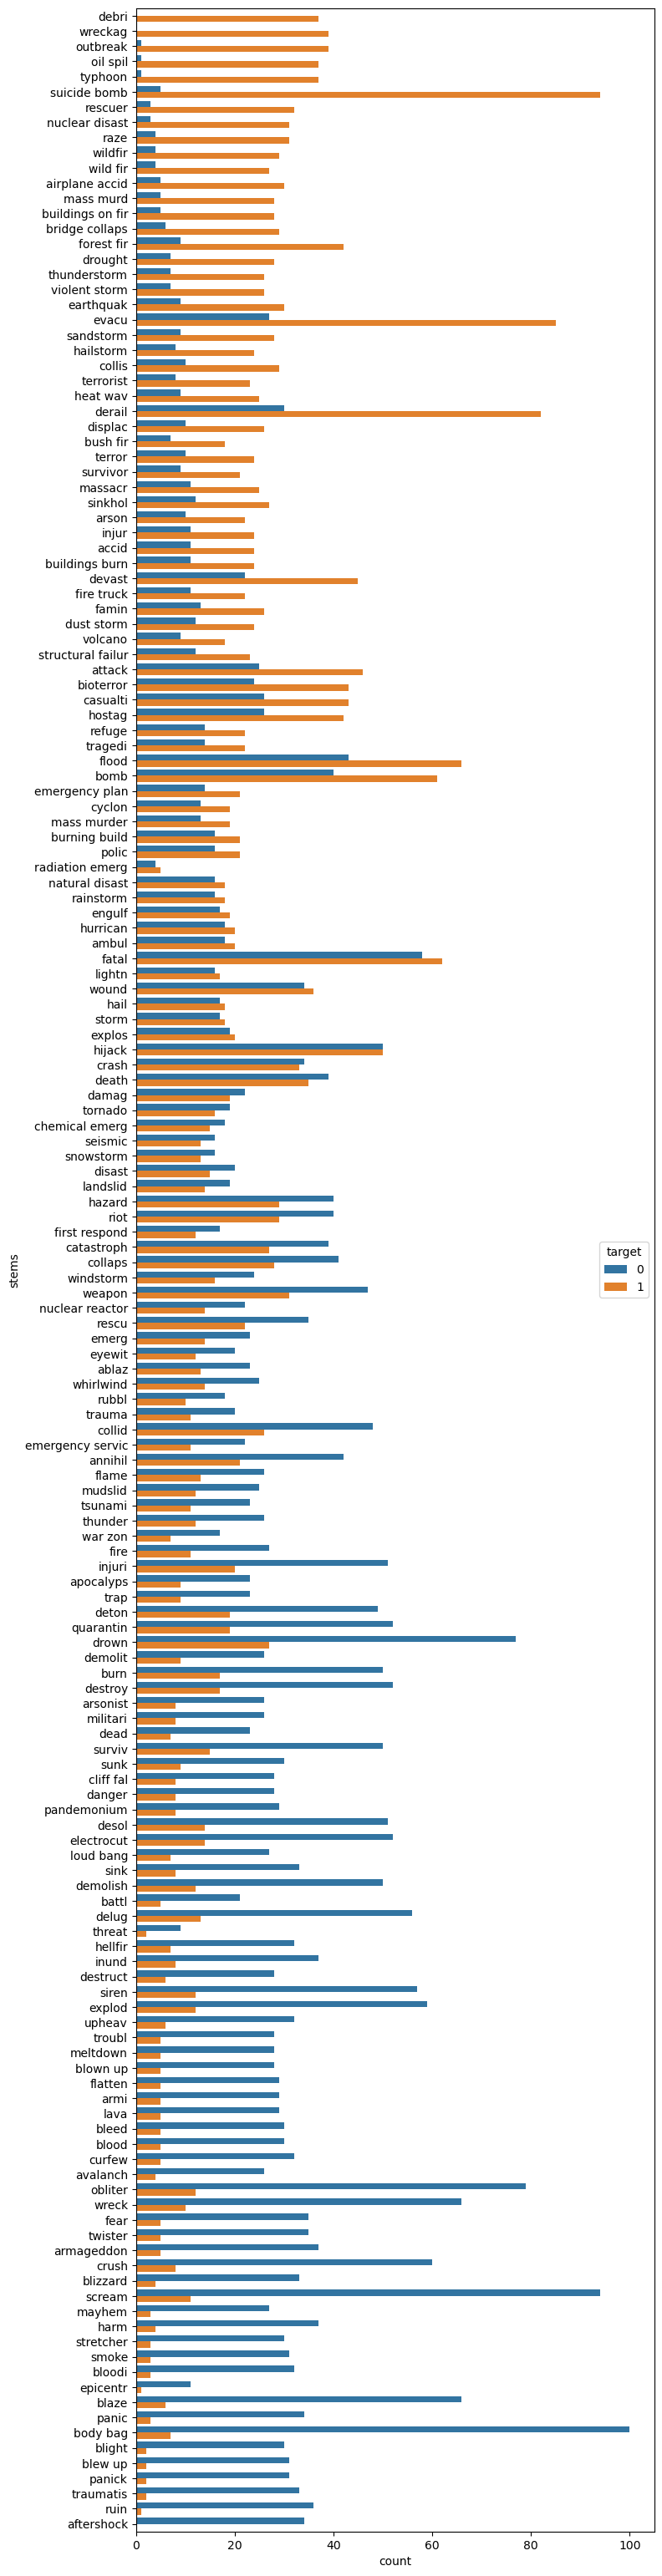

In [16]:
keywords['target_mean_stem'] = keywords.groupby('stems')['target'].transform('mean')
fig = plt.figure(figsize=(8, 40), dpi=100)
sns.countplot(y=keywords.sort_values(by='target_mean_stem', ascending = False)['stems'], 
              hue = keywords.sort_values(by='target_mean_stem', ascending =False)['target'])
plt.savefig('keywords_distributions.png', bbox_inches = 'tight')
plt.show()

In [17]:
def make_dict(tup, dictionary):
    for x, y in tup:
        dictionary.setdefault(x, []). append(y)
    return dictionary

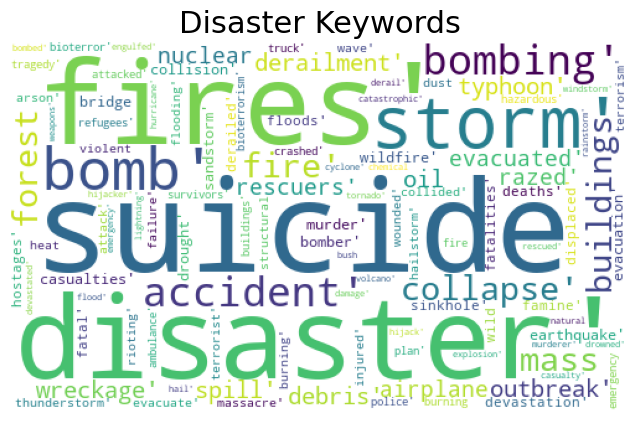

In [18]:
count = Counter(list(keywords[keywords['target']==1]['keyword']))
top_words = {}
make_dict(count.most_common(100), top_words)
df = pd.DataFrame.from_dict(top_words, orient = 'index').reset_index()
df.columns=['word', 'count']
text = df['word'].values
wordcloud_keywords = WordCloud(background_color = 'white', width = 500, height = 300, collocations = True).generate(str(text))
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(wordcloud_keywords)
plt.axis('off')
plt.title('Disaster Keywords', fontsize = 22)
plt.savefig('wordcloud_disaster_keywords.png', bbox_inches = 'tight')
plt.show()

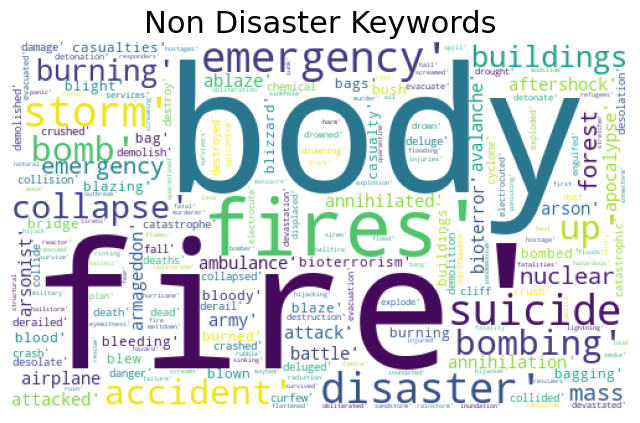

In [19]:
count = Counter(list(keywords[keywords['target']==0]['keyword']))
top_words = {}
make_dict(count.most_common(100), top_words)
df = pd.DataFrame.from_dict(top_words, orient = 'index').reset_index()
df = pd.DataFrame.from_dict(count, orient = 'index').reset_index()
df.columns=['word', 'count']
text = df['word'].values
wordcloud_keywords = WordCloud(background_color = 'white', width = 500, height = 300, collocations = True).generate(str(text))
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(wordcloud_keywords)
plt.axis('off')
plt.title('Non Disaster Keywords', fontsize = 22)
plt.savefig('wordcloud_non_disasterwords.png', bbox_inches = 'tight')
plt.show()

We do see some commonalities in the choice of keywords but we also see there are keywords that appear more frequently in one class compared to others: body bags for example appears a lot more frequently as a keyword for non disasterous tweets than disasterous tweets. There are a couple of words, debris and wreckage, which only appear as keywords for disaster tweets whilst aftershock only appears as a kew word in non disaster tweets. From this we can conclude that there aren't sufficent difference in the keywords to try and develop a classification model. As a result we will drop this for future analysis. 

#### 3.1.2 Location
There was a lot of missing data for location as we saw from our initial data exploration. 

In [20]:
location_disaster = data[data['target']==1].drop(['text','keyword', 'id'], axis = 1)
location_nondisaster = data[data['target']==0].drop(['text','keyword', 'id'], axis = 1)
print('Missing data for Disaster Tweets')
print((location_disaster.isnull().sum()/len(location_disaster))*100)
print('\n')
print('Missing data for Non Disaster Tweets')
print((location_nondisaster.isnull().sum()/len(location_nondisaster))*100)

Missing data for Disaster Tweets
location    32.864567
target       0.000000
dtype: float64


Missing data for Non Disaster Tweets
location    33.578996
target       0.000000
dtype: float64


Disaster and Non Disaster tweets seem to have the same proportion of missing data: roughly 34 percent. This is quite a large portion so this might not be a great feature to use for our classification model. 

In [21]:
location = data[data['location'].notnull()].drop(['text', 'keyword'], axis = 1)
location.head(2)
location

id                       location  target
31       48                     Birmingham       1
32       49  Est. September 2012 - Bristol       0
33       50                         AFRICA       1
34       52               Philadelphia, PA       0
35       53                     London, UK       0
...     ...                            ...     ...
7575  10826                             TN       0
7577  10829         #NewcastleuponTyne #UK       0
7579  10831              Vancouver, Canada       0
7580  10832                        London        0
7581  10833                        Lincoln       0

[5080 rows x 3 columns]

In [22]:
location['target'].value_counts()

0    2884
1    2196
Name: target, dtype: int64

In [23]:
print(location['location'].nunique())
print(len(location))

3341
5080


We notice that there are dates and other non-location based words in the entries. We definitely want to remove them and see if we cna determine if there is a pattern to these. So, let's start with cleaning the location entries like we did before with the keywords. 

In [24]:
location['location'] = location['location'].apply(lambda x: remove_accents(x))
location['location'] = location['location'].apply(lambda x: remove_punctuation(x))

In [25]:
#let's remove numerical entries
def remove_nums(location):
    cleaned = re.sub(r'\d+', '', location)
    return cleaned
location['location'] = location['location'].apply(lambda x: remove_nums(x))
def remove_extra_w_space(location):
    cleaned_text = re.sub(r"\s+"," ",location).strip()
    return cleaned_text
location['location'] = location['location'].apply(lambda x: remove_extra_w_space(x))

In [26]:
location['location'].nunique()

3106

Our cleaning process had reduced the number of unique entries to 3106 from 3341. 

In [27]:
location_disaster = location[location['target']==1]
location_nondisaster = location[location['target']==0]

In [28]:
nlp = en_core_web_sm.load()
tokens = nlp(''.join(str(location_disaster.location.tolist())))
items = [word.text for word in tokens.ents]
disasters = Counter(items).most_common(3000)

In [29]:
nlp = en_core_web_sm.load()
tokens = nlp(''.join(str(location_nondisaster.location.tolist())))
items = [word.text for word in tokens.ents]
non_disasters = Counter(items).most_common(3000)

In [30]:
x = list(set(disasters).intersection(non_disasters))
len(x)

82

There are only 82 locations in common between the two classes out of 5080 entries

In [31]:
print(x)

[('Orange County', 1), ('Virginia', 2), ("Cairo Egypt'", 1), ("Spare Oom'", 1), ("Louisville KY'", 1), ('Italy', 1), ("Gold Coast Australia'", 1), ('Denver', 1), ('Norway', 1), ('Germany', 2), ("Mackay QLD Australia'", 1), ("Hampshire UK'", 1), ("Miami Beach'", 1), ("North Carolina USA'", 2), ("Johannesburg South Africa'", 2), ("Federal Capital Territory'", 1), ("'Cumming GA'", 1), ('Buenos Aires', 2), ('Malaysia', 3), ("West Virginia USA'", 1), ('Tokyo', 3), ('New York', 1), ('Belgium', 1), ('Kansas City', 2), ('Shadows', 1), ('Connecticut', 1), ("Niagara Falls Ontario'", 1), ("Eugene Oregon'", 1), ("Houston TX'", 6), ("Palo Alto CA'", 1), ("Paris France'", 1), ("Philadelphia PA'", 3), ('Istanbul', 1), ("Boston Strong'", 1), ("New Delhi'", 1), ("U K'", 2), ("Knoxville TN'", 1), ('San Diego', 2), ("Dubai UAE'", 1), ("Melbourne Victoria'", 1), ('California', 16), ("Dublin City Ireland'", 1), ("Abuja Nigeria'", 1), ("Austin TX'", 4), ('iPhone', 1), ("SF Bay Area'", 1), ("Washington USA'"

### 3.2 Tweets

In [32]:
tweets = data.drop(['keyword', 'location', 'id'], axis = 1)

In [33]:
tweets.head()

text  target
0  Our Deeds are the Reason of this #earthquake M...       1
1             Forest fire near La Ronge Sask. Canada       1
2  All residents asked to 'shelter in place' are ...       1
3  13,000 people receive #wildfires evacuation or...       1
4  Just got sent this photo from Ruby #Alaska as ...       1

Here we want to do 2 things:
> 1. We want to clean the tweets so we can apply machine learning algorithms
> 2. Extract basic features from the tweets to see what would be valuable to use for our classification models. 

The order fo our cleaning and feature extraction will need to be varied as some features will need to be extracted before the cleaning process, such as hastags and mentions won't exist if we remove punctuation. 

#### 3.2.1 Hashtags, Mentions, and Emojis

In [34]:
def hash_count(string):
    words = string.split()
    hashtags = [word for word in words if word.startswith('#')]
    return len(hashtags)
tweets['num_hashtags'] = tweets['text'].apply(hash_count)
tweets['hashtags'] = tweets['text'].apply(lambda x: [x for x in x.split(" ") if x.startswith("#")])
def mention_count(string):
    words = string.split()
    mentions = [word for word in words if word.startswith('@')]
    return len(mentions)
tweets['num_mentions'] = tweets['text'].apply(mention_count)
tweets['mentions'] = tweets['text'].apply(lambda x: [x for x in x.split(" ") if x.startswith("@")])
def emoji_count(tweet):
    tweet = emoji.demojize(tweet, delimiters=('__','__'))
    pattern = r'_+[a-z_&]+_+'
    return len(re.findall(pattern, tweet))
tweets['emojis'] = tweets['text'].apply(emoji_count)

In [35]:
#let's explore the difference in the tweets for disaster and non disasters. 
disaster_tweets = tweets[tweets['target']==1]
nondisaster_tweets = tweets[tweets['target']==0]

#### Hashtags

In [36]:
print('Summary of Number of Words in Disaster Tweets:')
print(disaster_tweets.num_hashtags.describe())
print('\n')
print('Summary of Number of Words in Non Disaster Tweets:')
print(nondisaster_tweets.num_hashtags.describe())

Summary of Number of Words in Disaster Tweets:
count    3271.000000
mean        0.509019
std         1.196259
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        13.000000
Name: num_hashtags, dtype: float64


Summary of Number of Words in Non Disaster Tweets:
count    4342.000000
mean        0.385767
std         0.999060
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        11.000000
Name: num_hashtags, dtype: float64


We can see that the number of hastags used ranges from 1-2 on the whole, but disaster tweets seem to have a slightly higher mean. What's noteworthy is the tweets with 11-13 hashtags. Let's inspect these further. 

In [37]:
tweets[tweets['num_hashtags']>=11]

text  target  num_hashtags  \
312   RT @Ophiuchus2613: #Love #TrueLove #romance li...       0            11   
318   RT @RTRRTcoach: #Love #TrueLove #romance lith ...       0            11   
4468  No #news of #hostages in #Libya\n\nhttp://t.co...       1            13   
4480  No #news of #hostages in #Libya\n\nhttp://t.co...       1            13   
4483  No #news of #hostages in #Libya\n\nhttp://t.co...       1            13   
7197  Rare insight into #terror and How to fight it ...       1            13   

                                               hashtags  num_mentions  \
312   [#Love, #TrueLove, #romance, #Voodoo, #seducti...             1   
318   [#Love, #TrueLove, #romance, #Voodoo, #seducti...             1   
4468  [#news, #hostages, #Libya\n\nhttp://t.co/eXil1...             0   
4480  [#news, #hostages, #Libya\n\nhttp://t.co/bjjOI...             0   
4483  [#news, #hostages, #Libya\n\nhttp://t.co/k9FBt...             0   
7197  [#terror, #Cameroon, #USA, #Whitehouse, #ES, #...             0   

               mentions  emojis  
312   [@Ophiuchus2613:]       0  
318      [@RTRRTcoach:]       0  
4468                 []       0  
4480                 []       0  
4483                 []       0  
7197                 []       0

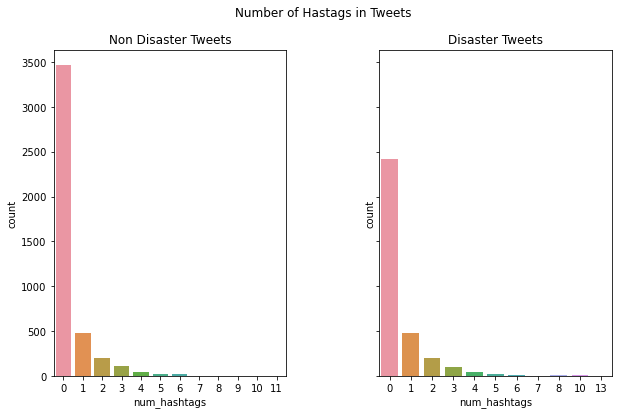

In [38]:
fig, ax = plt.subplots(1,2, figsize=(10,6), sharey=True)
fig.suptitle('Number of Hastags in Tweets')
sns.countplot(x=tweets[tweets['target']==0]['num_hashtags'], data=tweets, ax=ax[0])
sns.countplot(x=tweets[tweets['target']==1]['num_hashtags'], data=tweets, ax=ax[1])
ax[0].set_title('Non Disaster Tweets')
ax[1].set_title('Disaster Tweets')
plt.subplots_adjust(wspace=0.4)
plt.savefig('Num_hashtags.png', bbox_inches = 'tight')
plt.show()

Both of the classes have the same trend where majority of the tweets have no hashtags. So we can remove the hashtags and not worry too much about losing valuable information. 

#### Mentions

In [39]:
print('Summary of Number of Words in Disaster Tweets:')
print(disaster_tweets.num_mentions.describe())
print('\n')
print('Summary of Number of Words in Non Disaster Tweets:')
print(nondisaster_tweets.num_mentions.describe())

Summary of Number of Words in Disaster Tweets:
count    3271.000000
mean        0.265668
std         0.612843
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: num_mentions, dtype: float64


Summary of Number of Words in Non Disaster Tweets:
count    4342.000000
mean        0.413404
std         0.759633
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         8.000000
Name: num_mentions, dtype: float64


In [40]:
tweets[tweets['num_hashtags']>=5]

text  target  num_hashtags  \
12    #raining #flooding #Florida #TampaBay #Tampa 1...       1             5   
104   320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yN...       0             6   
106   320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...       0             6   
114   320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/M4...       0             6   
115   320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...       0             6   
...                                                 ...     ...           ...   
7300  God forbid this is true #California has enough...       1             5   
7350  This machine really captured my attention. #he...       1             5   
7438  Read ~ THE UNHEALED WOUNDS OF AN UNENDING CONF...       1             6   
7480  Ranking #artectura #pop2015 #Nå¼36 Florence + ...       0             6   
7596  RT @LivingSafely: #NWS issues Severe #Thunders...       1             5   

                                               hashtags  num_mentions  \
12    [#raining, #flooding, #Florida, #TampaBay, #Ta...             0   
104   [#Dubstep, #TrapMusic, #DnB, #EDM, #Dance, #Ic...             1   
106   [#Dubstep, #TrapMusic, #DnB, #EDM, #Dance, #Ic...             1   
114   [#Dubstep, #TrapMusic, #DnB, #EDM, #Dance, #Ic...             1   
115   [#Dubstep, #TrapMusic, #DnB, #EDM, #Dance, #Ic...             1   
...                                                 ...           ...   
7300  [#California, #drought, #wild, #Nuclear, #SanO...             0   
7350  [#helicopter, #firefighting, #wildfire, #orego...             0   
7438  [#Kashmir, #Pakistan, #India, #EndOccupation, ...             0   
7480  [#artectura, #pop2015, #Nå¼36, #music, #playli...             0   
7596              [#NWS, #Thunderstorm, #AR, #NC, #OK.]             1   

              mentions  emojis  
12                  []       0  
104       [@djicemoon]       0  
106       [@djicemoon]       0  
114       [@djicemoon]       0  
115       [@djicemoon]       0  
...                ...     ...  
7300                []       0  
7350                []       0  
7438                []       0  
7480                []       0  
7596  [@LivingSafely:]       0  

[97 rows x 7 columns]

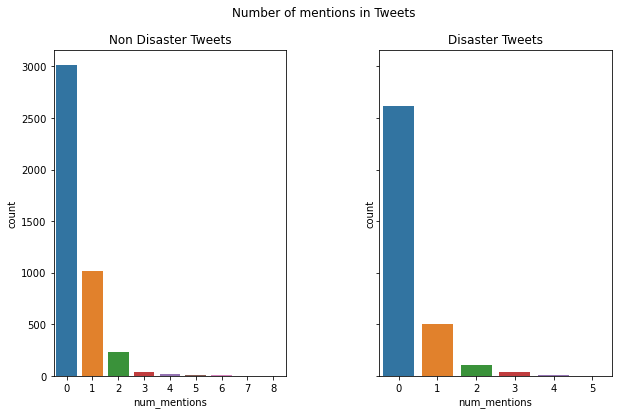

In [41]:
fig, ax = plt.subplots(1,2, figsize=(10,6), sharey=True)
fig.suptitle('Number of mentions in Tweets')
sns.countplot(x=tweets[tweets['target']==0]['num_mentions'], data=tweets, ax=ax[0])
sns.countplot(x=tweets[tweets['target']==1]['num_mentions'], data=tweets, ax=ax[1])
ax[0].set_title('Non Disaster Tweets')
ax[1].set_title('Disaster Tweets')
plt.subplots_adjust(wspace=0.4)
plt.savefig('Num_mentions.png', bbox_inches = 'tight')
plt.show()

The trend again follows the same trend as we saw in hashtags- majority of the tweets have no mentions. It's interesting to see that the range of number of mentions is larger than the range for danger tweets. 

#### Emojis

In [42]:
print('Summary of Number of Words in Disaster Tweets:')
print(disaster_tweets.emojis.describe())
print('\n')
print('Summary of Number of Words in Non Disaster Tweets:')
print(nondisaster_tweets.emojis.describe())

Summary of Number of Words in Disaster Tweets:
count    3271.000000
mean        0.003974
std         0.062926
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: emojis, dtype: float64


Summary of Number of Words in Non Disaster Tweets:
count    4342.000000
mean        0.003685
std         0.060599
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: emojis, dtype: float64


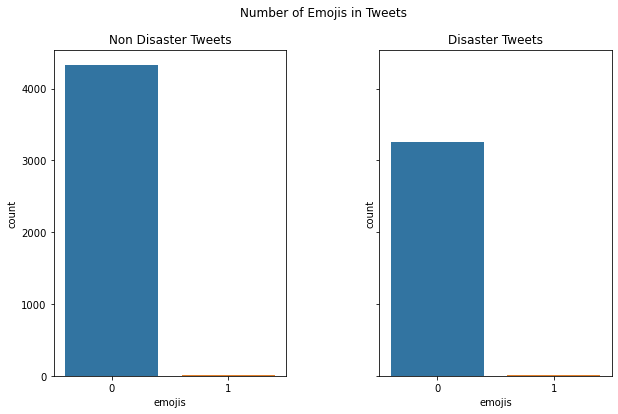

In [43]:
fig, ax = plt.subplots(1,2, figsize=(10,6), sharey=True)
fig.suptitle('Number of Emojis in Tweets')
sns.countplot(x=tweets[tweets['target']==0]['emojis'], data=tweets, ax=ax[0])
sns.countplot(x=tweets[tweets['target']==1]['emojis'], data=tweets, ax=ax[1])
ax[0].set_title('Non Disaster Tweets')
ax[1].set_title('Disaster Tweets')
plt.subplots_adjust(wspace=0.4)
plt.savefig('num_emojis.png', bbox_inches = 'tight')
plt.show()

#### Comments



#### 3.2.2 Cleaning Tweets
Now we have extracted features that rely on punctuation and special characters, we can proceed to cleaning the tweets.
> First let's expand all common contractions. These will include abbreviations and colloquial slang. We need to do this before removing punctuation as these rely on the use of apostrophes. 

#### Colloquial Words and Common Contractions
For this I will be using a dictionary of abbreviations from https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt


In [44]:
colloquial_contractions = {'AFAIK': 'As Far As I Know',
    'AFK': 'Away From Keyboard',
    'ASAP': 'As Soon As Possible',
    'ATK': 'At The Keyboard',
    'ATM': 'At The Moment',
    'A3': 'Anytime, Anywhere, Anyplace',
    'BAK': 'Back At Keyboard',
    'BBL': 'Be Back Later',
    'BBS': 'Be Back Soon',
    'BFN': 'Bye For Now',
    'B4N': 'Bye For Now',
    'BRB': 'Be Right Back',
    'BRT': 'Be Right There',
    'BTW': 'By The Way',
    'B4': 'Before',
    'B4N': 'Bye For Now',
    'CU': 'See You',
    'CUL8R': 'See You Later',
    'CYA': 'See You',
    'FAQ': 'Frequently Asked Questions',
    'FC': 'Fingers Crossed',
    'FWIW': 'For What It\'s Worth',
    'FYI': 'For Your Information',
    'GAL': 'Get A Life',
    'GG': 'Good Game',
    'GN': 'Good Night',
    'GMTA': 'Great Minds Think Alike',
    'GR8': 'Great!',
    'G9': 'Genius',
    'IC': 'I See',
    'ICQ': 'I Seek you',
    'ILU': 'I Love You',
    'IMHO': 'In My Humble Opinion',
    'IMO': 'In My Opinion',
    'IOW': 'In Other Words',
    'IRL': 'In Real Life',
    'KISS': 'Keep It Simple, Stupid',
    'LDR': 'Long Distance Relationship',
    'LMAO': 'Laugh My Ass Off',
    'LOL': 'Laughing Out Loud',
    'LTNS': 'Long Time No See',
    'L8R': 'Later',
    'MTE': 'My Thoughts Exactly',
    'M8': 'Mate',
    'NRN': 'No Reply Necessary',
    'OIC': 'Oh I See',
    'OMG': 'Oh My God',
    'PITA': 'Pain In The Ass',
    'PRT': 'Party',
    'PRW': 'Parents Are Watching',
    'QPSA?': 'Que Pasa?',
    'ROFL': 'Rolling On The Floor Laughing',
    'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
    'ROTFLMAO': 'Rolling On The Floor Laughing My Ass Off',
    'SK8': 'Skate',
    'STATS': 'Your sex and age',
    'ASL': 'Age, Sex, Location',
    'THX': 'Thank You',
    'TTFN': 'Ta-Ta For Now!',
    'TTYL': 'Talk To You Later',
    'U': 'You',
    'U2': 'You Too',
    'U4E': 'Yours For Ever',
    'WB': 'Welcome Back',
    'WTF': 'What The Fuck',
    'WTG': 'Way To Go!',
    'WUF': 'Where Are You From?',
    'W8': 'Wait',
    '7K': 'Sick:-D Laugher'}
def expand_colloquialisms(tweet):
    if tweet.upper() in colloquial_contractions.keys():
        return colloquial_contractions[tweet.upper()]
    else:
        return tweet
    
tweets['text'] = tweets['text'].apply(lambda x: expand_colloquialisms(x))

#let's expand on the common contractions we found earlier. 
def expand_contractions(tweet):
    return contractions.fix(tweet)
tweets['text'] = tweets['text'].apply(lambda x: expand_contractions(x))

#### Removing Emojis- will removing punctuation take care of this?
We are going to use the codes from: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b

In [45]:
def demojize(tweet):
    emojis = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags = re.UNICODE)
    cleaned_text = emojis.sub(r'', tweet)
    return cleaned_text
tweets['text'] = tweets['text'].apply(lambda x: demojize(x))

In [46]:
demojize('hello :) :( )')

'hello :) :( )'

In [47]:
def emojis(tweet):
    tweet = emoji.demojize(tweet)
    tweet = tweet.replace(':','')
    cleaned_text = ' '.join(tweet.split())
    return cleaned_text

> Now we are going to remove all html texts, urls, punctuation including hastags, mentions, emojis and accents. 

We already have functions we wrote earlier for accents and punctuation so we can just call those directly 

In [48]:
tweets['text'] = tweets['text'].apply(lambda x: remove_accents(x))
tweets['text'] = tweets['text'].apply(lambda x: remove_punctuation(x))

Now to remove hastags, mentions, html, urls

In [49]:
#now let's remove the hashtags, mentions, html text, numbers, and urls 
def remove_hashtag(tweet):
    cleaned_text = re.sub(r'#\w+','',tweet)
    return cleaned_text
tweets['text'] = tweets['text'].apply(lambda x: remove_hashtag(x))
def remove_mentions(tweet):
    cleaned_text = re.sub(r'@\w+|@[^\s]+','',tweet)
    return cleaned_text
tweets['text'] = tweets['text'].apply(lambda x: remove_mentions(x))
def remove_html_text(tweet):
    html_text = re.compile(r'<.*?>|\n|\t|\&\w*;z|\$\w*')
    cleaned_text = html_text.sub(r'',tweet)
    return cleaned_text
tweets['text'] = tweets['text'].apply(lambda x: remove_html_text(x))
def remove_url_text(tweet):
    url = re.compile(r'https?://\S+|www\.\S+|http://t.co/|http|https?:\/\/.*\/\w*')
    cleaned_text = url.sub(r'',tweet)
    return cleaned_text
tweets['text'] = tweets['text'].apply(lambda x: remove_url_text(x))


Let's now remove numbers and make all of the text lowercase. 

In [50]:
#remove numerical values 
def remove_nums(tweet):
    cleaned_text = re.sub(r'\d+', '', tweet)
    return cleaned_text
tweets['text'] = tweets['text'].apply(lambda x: remove_nums(x))
#change all tweets to lower case
def lower_case(tweet):
    lower_case = tweet.lower()
    return lower_case
tweets['text'] = tweets['text'].apply(lambda x: lower_case(x))

In [51]:
def remove_extra_w_space(tweet):
    cleaned_text = re.sub(r"\s+"," ",tweet).strip()
    return cleaned_text
tweets['text'] = tweets['text'].apply(lambda x: remove_extra_w_space(x) )
#lets also remove any white space before the tweets
tweets['text'] = tweets['text'].apply(lambda x: x.lstrip(' '))
tweets

text  target  num_hashtags  \
0     our deeds are the reason of this earthquake ma...       1             1   
1                 forest fire near la ronge sask canada       1             0   
2     all residents asked to shelter in place are be...       1             0   
3     people receive wildfires evacuation orders in ...       1             1   
4     just got sent this photo from ruby alaska as s...       1             2   
...                                                 ...     ...           ...   
7608  two giant cranes holding a bridge collapse int...       1             0   
7609  aria ahrary thetawniest the out of control wil...       1             0   
7610        m utc km s of volcano hawaii t co zdtoydebj       1             0   
7611  police investigating after an e bike collided ...       1             0   
7612  the latest more homes razed by northern califo...       1             0   

                   hashtags  num_mentions                      mentions  \
0             [#earthquake]             0                            []   
1                        []             0                            []   
2                        []             0                            []   
3              [#wildfires]             0                            []   
4     [#Alaska, #wildfires]             0                            []   
...                     ...           ...                           ...   
7608                     []             0                            []   
7609                     []             2  [@aria_ahrary, @TheTawniest]   
7610                     []             0                            []   
7611                     []             0                            []   
7612                     []             0                            []   

      emojis  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
7608       0  
7609       0  
7610       0  
7611       0  
7612       0  

[7613 rows x 7 columns]

#### 3.2.3 Feature Extraction

In [52]:
#number of charecters (including white space) in each tweet
tweets['num_chars'] = tweets['text'].apply(len)
#number of words 
def word_count(string):
    words = string.split()
    return len(words)
tweets['num_words'] = tweets['text'].apply(word_count)
# average word length
def mean_word_length(x):
    words = x.split() #split the sentences into words
    word_len = [len(word) for word in words] #count the length of each word in the sentence
    mean_word_length = sum(word_len)/len(words)
    return(mean_word_length)
tweets['mean_word_length'] = tweets['text'].apply(mean_word_length)
#let's update our disaster and non disaster dataframes 
disaster_tweets = tweets[tweets['target']==1]
nondisaster_tweets = tweets[tweets['target']==0]
tweets.head(2)

text  target  num_hashtags  \
0  our deeds are the reason of this earthquake ma...       1             1   
1              forest fire near la ronge sask canada       1             0   

        hashtags  num_mentions mentions  emojis  num_chars  num_words  \
0  [#earthquake]             0       []       0         68         13   
1             []             0       []       0         37          7   

   mean_word_length  
0          4.307692  
1          4.428571

#### Number of Characters

In [53]:
print('Summary of Number of Characters in Disaster Tweets:')
print(disaster_tweets.num_chars.describe())
print('\n')
print('Summary of Number of Characters in Non Disaster Tweets:')
print(nondisaster_tweets.num_chars.describe())

Summary of Number of Characters in Disaster Tweets:
count    3271.000000
mean       96.237848
std        27.436593
min        14.000000
25%        76.000000
50%       100.000000
75%       120.000000
max       143.000000
Name: num_chars, dtype: float64


Summary of Number of Characters in Non Disaster Tweets:
count    4342.000000
mean       87.133809
std        33.238305
min         3.000000
25%        61.000000
50%        91.000000
75%       116.000000
max       147.000000
Name: num_chars, dtype: float64


Let's look at the tweets with the greatest and least number of characters

In [54]:
nondisaster_tweets[nondisaster_tweets['num_chars']==147]['text']

2301    nah but srsly b you demolish ur partner s face...
4801    it is was about in the morning amp i went down...
5379    savs contact fell out but she was convinced it...
Name: text, dtype: object

In [55]:
nondisaster_tweets[nondisaster_tweets['num_chars']==3]['text']

5115    err
Name: text, dtype: object

In [56]:
disaster_tweets[disaster_tweets['num_chars']==143]['text']

5096    we want to see no more hiroshima and nagasaki ...
Name: text, dtype: object

In [57]:
disaster_tweets[disaster_tweets['num_chars']==14]['text']

4504    hurricane sick
7589    omg earthquake
Name: text, dtype: object

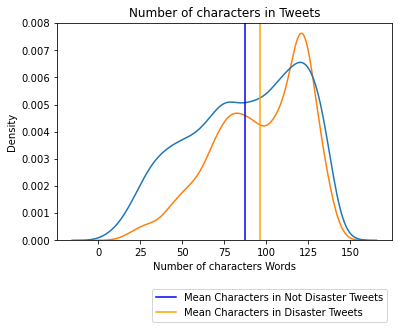

In [58]:
_ = sns.kdeplot(x='num_chars', hue='target', data = tweets)
_ = plt.axvline(x=tweets[tweets['target']==0]['num_chars'].mean(), color='blue', label='Mean Characters in Not Disaster Tweets')
_ = plt.axvline(x=tweets[tweets['target']==1]['num_chars'].mean(), color = 'orange', label='Mean Characters in Disaster Tweets')
_ = plt.title('Number of characters in Tweets')
_ = plt.xlabel('Number of characters Words')
_ = plt.legend(bbox_to_anchor = (1,-0.2))
_ = plt.savefig('Num_characters.png', bbox_inches = 'tight')
_ = plt.show()

#### Number of words in Tweets
When looking at the number of characters in tweets, we saw that some of the tweets were one-two words long and one of these instances included and error message. I think it's a good idea to limit the number of words to 2 or more for each tweet but before doing so let's explore the number of words in tweets in the two different classes. 

In [59]:
#let's explore the difference in the tweets for disaster and non disasters. 
print('Summary of Number of Words in Disaster Tweets:')
print(disaster_tweets.num_words.describe())
print('\n')
print('Summary of Number of Words in Non Disaster Tweets:')
print(nondisaster_tweets.num_words.describe())

Summary of Number of Words in Disaster Tweets:
count    3271.000000
mean       16.619382
std         5.024805
min         2.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        33.000000
Name: num_words, dtype: float64


Summary of Number of Words in Non Disaster Tweets:
count    4342.000000
mean       15.869876
std         6.288566
min         1.000000
25%        11.000000
50%        16.000000
75%        21.000000
max        32.000000
Name: num_words, dtype: float64


In [60]:
tweets[tweets['num_words']==1]

text  target  num_hashtags hashtags  num_mentions mentions  \
24       looooool       0             0       []             0       []   
28         cooool       0             0       []             0       []   
1882      crushed       0             0       []             0       []   
3667     fatality       0             0       []             0       []   
3670     fatality       0             0       []             0       []   
3696     fatality       0             0       []             0       []   
4971     meltdown       0             0       []             0       []   
5115          err       0             0       []             0       []   
5184  obliterated       0             0       []             0       []   
6015      screams       0             0       []             0       []   
6522      survive       0             0       []             0       []   
6705      thunder       0             0       []             0       []   

      emojis  num_chars  num_words  mean_word_length  
24         0          8          1               8.0  
28         0          6          1               6.0  
1882       0          7          1               7.0  
3667       0          8          1               8.0  
3670       0          8          1               8.0  
3696       0          8          1               8.0  
4971       0          8          1               8.0  
5115       0          3          1               3.0  
5184       0         11          1              11.0  
6015       0          7          1               7.0  
6522       0          7          1               7.0  
6705       0          7          1               7.0

In [61]:
tweets[tweets['num_words']==2]

text  target  num_hashtags hashtags  num_mentions  \
22                  love skiing       0             0       []             0   
30                      the end       0             0       []             0   
276           apocalypse please       0             0       []             0   
323   paddytomlinson armageddon       0             0       []             1   
481              anxiety attack       0             0       []             0   
699               still blazing       0             0       []             0   
783           kynespeace blight       0             0       []             1   
784                   poor jack       0             0       []             0   
849                   rip blood       0             0       []             0   
2496              eggs desolate       0             0       []             0   
2734   mikeparractor devastated       0             0       []             1   
3058           earthquake drill       0             0       []             0   
3060           earthquake drill       1             0       []             0   
3074       electrocute yourself       0             0       []             0   
3137          emergency surgery       0             0       []             0   
3608           fatal attraction       0             0       []             0   
3681     babybackreeve fatality       0             0       []             1   
3686          chrisman fatality       0             0       []             1   
4504             hurricane sick       1             0       []             0   
4890                    bad day       0             0       []             0   
5564       nathanfillion hardly       0             0       []             1   
5952    bizzlemahomie screaming       0             0       []             1   
5962         scalpium screaming       0             0       []             1   
5983         danemillar screams       0             0       []             1   
5987         screams internally       0             0       []             0   
5998       realjaxclone screams       0             0       []             1   
6277                 this storm       0             0       []             0   
7448            puncture wounds       0             0       []             0   
7567           wrecked emotions       0             0       []             0   
7587          sirens everywhere       0             0       []             0   
7589             omg earthquake       1             0       []             0   

                mentions  emojis  num_chars  num_words  mean_word_length  
22                    []       0         11          2               5.0  
30                    []       0          7          2               3.0  
276                   []       0         17          2               8.0  
323   [@paddytomlinson1]       0         25          2              12.0  
481                   []       0         14          2               6.5  
699                   []       0         13          2               6.0  
783        [@kynespeace]       0         17          2               8.0  
784                   []       0          9          2               4.0  
849                   []       0          9          2               4.0  
2496                  []       0         13          2               6.0  
2734    [@MikeParrActor]       0         24          2              11.5  
3058                  []       0         16          2               7.5  
3060                  []       0         16          2               7.5  
3074                  []       0         20          2               9.5  
3137                  []       0         17          2               8.0  
3608                  []       0         16          2               7.5  
3681    [@Babybackreeve]       0         22          2              10.5  
3686      [@Chrisman528]       0         17          2               8.0  
4504                  []       0         

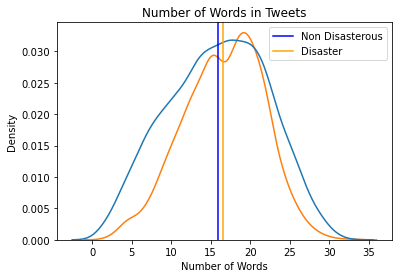

In [62]:
sns.kdeplot(x='num_words', hue='target', data = tweets)
plt.axvline(x=tweets[tweets['target']==0]['num_words'].mean(), color='blue', label='Non Disasterous')
plt.axvline(x=tweets[tweets['target']==1]['num_words'].mean(), color = 'orange', label='Disaster')
plt.title('Number of Words in Tweets')
plt.xlabel('Number of Words')
plt.savefig('Num_words.png', bbox_inches = 'tight')
plt.legend();

The distribution of number of words seem to be bimodal. The two classes, as expected from inspecting the summary information, do have a very similar shape. 

#### Length of words

In [63]:
#let's explore the difference in the tweets for disaster and non disasters. 
print('Summary of Length of Words in Disaster Tweets:')
print(disaster_tweets.mean_word_length.describe())
print('\n')
print('Summary of Length of Words in Non Disaster Tweets:')
print(nondisaster_tweets.mean_word_length.describe())

Summary of Length of Words in Disaster Tweets:
count    3271.000000
mean        4.928307
std         0.743798
min         2.625000
25%         4.428571
50%         4.909091
75%         5.333333
max        10.000000
Name: mean_word_length, dtype: float64


Summary of Length of Words in Non Disaster Tweets:
count    4342.000000
mean        4.667966
std         0.918470
min         2.250000
25%         4.055556
50%         4.563859
75%         5.131250
max        12.000000
Name: mean_word_length, dtype: float64


The IQR varies only very slightly between the two classes, but the maximum length of the words do vary quite a bit. Let's look the minimums and maximums in a little more detail first. 

In [64]:
tweets[tweets['mean_word_length']<=3]

text  target  num_hashtags  \
7     i am on top of the hill and i can see a fire i...       1             0   
15                                       what is up man       0             0   
18                                    my car is so fast       0             0   
30                                              the end       0             0   
522   i bet you did not know i kick box too s t co r...       0             0   
659            yo i got bars and i am not even a rapper       0             0   
675                                  yes i do have guns       0             0   
856                      we gone get it get it in blood       0             0   
868                         if it was not for the blood       0             0   
870                          are not no hoe in my blood       1             0   
982       nuu that fam fwt i am leave you in a body bag       0             0   
1023          are not no bags in the trunk it is a body       0             0   
1573                 do me a favor and fall off a cliff       0             0   
1580                        i hope you fall off a cliff       0             0   
1790                        am boy crash s t co fylppfn       0             0   
1855                            i am my own woman crush       0             0   
1863    i am so high moe i am bouta crush this friday s       0             0   
1880  do he love me do he love me not i are not a pl...       0             0   
2085                  that is it val is dead i am suing       1             0   
2783                    i am a disaster s t co vcvbuacz       0             0   
2897  some days i drown in my tears but i do not let...       0             0   
3052  gpv wind as of jst aug wnw jst aug e jst aug s...       0             0   
3749                                         i see fire       0             0   
3758                    well it feels like i am on fire       0             0   
3768                    i want to set some shit on fire       1             0   
4034  p for those who watch over me forest fire smok...       1             0   
4091                    hail zel man you kno i am there       0             0   
4092                         hail pic uo s t co bomjuei       0             0   
4169  all i got in this world is my bros i do not wa...       0             0   
4731                                         i lava you       0             0   
4735                                         i lava you       0             0   
4890                                            bad day       0             0   
5115                                                err       0             0   
5357                                 it is do not panic       0             0   
5365            is it time to panic now s t co orxdqfzj       0             0   
5425  my sis can now sit on a cam w o panicking s t ...       0             0   
5869  clnv yes yes i will i do not want to ruin my l...       0             0   
5873                   i will ruin my life if i have to       0             0   
5874     babe i am going to ruin you if you let me stay       0             0   
6205                                    i want to smoke       0             0   
6217                be trynna smoke tj out but he a hoe       0             0   
6221                    i get to smoke my shit in peace       1             0   
6269  is it bad to say that i am kind of afraid of s...       1             0   
6485          i am getting a car wow it has not sunk in       0             0   
6547  such a lonely day and it is mine it is a day t...       0             0   
6943                                 i feel so lucky rn       0             0   
6952     it is my senior year i just want to go all out       0             0   
6977  it is alil twister at tha end to i was like oh...       1             0   
7470                                       i am a wreck       0             0   



We do see these shorter tweets are more common in target class 0, the non disaster tweets, that in class 1

In [65]:
tweets[tweets['mean_word_length']>=12]

text  target  num_hashtags hashtags  num_mentions  \
323  paddytomlinson armageddon       0             0       []             1   

               mentions  emojis  num_chars  num_words  mean_word_length  
323  [@paddytomlinson1]       0         25          2              12.0

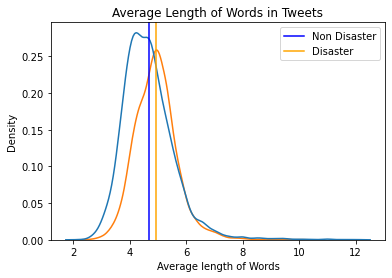

In [66]:
sns.kdeplot(x='mean_word_length', hue='target', data = tweets)
plt.axvline(x=tweets[tweets['target']==0]['mean_word_length'].mean(), color='blue', label='Non Disaster')
plt.axvline(x=tweets[tweets['target']==1]['mean_word_length'].mean(), color = 'orange', label='Disaster')
plt.title('Average Length of Words in Tweets')
plt.xlabel('Average length of Words')
plt.savefig('mean_word_length.png', bbox_inches = 'tight')
plt.legend()

#### Stopwords
We now have to think about removing stopwords. We saw from earlier that we can remove words with 2 or less characters as these don't seem to make a difference anyway between the two clasess, and can help eliminitate typos and staggling characters. So, let's do these first. 

In [67]:
def two_or_less(tweet):
    cleaned_text = re.sub(r'\b\w{1,2}\b','',tweet)
    return cleaned_text
tweets['text'] = tweets['text'].apply(lambda x: two_or_less(x))
#now let's again remove any additional white space that now appear
def remove_extra_w_space(tweet):
    cleaned_text = re.sub(r"\s+"," ",tweet).strip()
    return cleaned_text
tweets['text'] = tweets['text'].apply(lambda x: remove_extra_w_space(x) )
#lets also remove any white space before the tweets
tweets['text'] = tweets['text'].apply(lambda x: x.lstrip(' '))
tweets.head(2)

text  target  num_hashtags  \
0  our deeds are the reason this earthquake may a...       1             1   
1                 forest fire near ronge sask canada       1             0   

        hashtags  num_mentions mentions  emojis  num_chars  num_words  \
0  [#earthquake]             0       []       0         68         13   
1             []             0       []       0         37          7   

   mean_word_length  
0          4.307692  
1          4.428571

Let's see if we can identify more stop words by using a vectorizer. Let's look at using: 
> Count Vectorizer <br>
> Tf-IDF

##### Count Vectorizer

In [68]:
X = tweets['text']
y = tweets['target']
cv_vectorizer = CountVectorizer()
vectorizer_train = cv_vectorizer.fit_transform(X)
print(cv_vectorizer.get_feature_names()[:100])

['aaaa', 'aaaaaaallll', 'aaaaaand', 'aaarrrgghhh', 'aace', 'aadzvsr', 'aaemiddle', 'aal', 'aamir', 'aan', 'aannnnd', 'aar', 'aaronthefm', 'aashiqui', 'aattamnmd', 'aauizggcq', 'aawzxykles', 'aba', 'abandon', 'abandoned', 'abandonedpics', 'abandoning', 'abbandoned', 'abbott', 'abbruchsimulator', 'abbswinston', 'abbyairshow', 'abc', 'abcchicago', 'abceyewitness', 'abcnews', 'abcnorio', 'abe', 'aberdeen', 'aberdeenfanpage', 'aberdeenfc', 'aberystwyth', 'abgctvfua', 'abgfglhx', 'abha', 'abia', 'ability', 'abjabhqhe', 'abject', 'ablaze', 'able', 'ableg', 'ablzmgzv', 'abninfvet', 'abnlseqb', 'abnrcr', 'abnzqwlig', 'aboard', 'abolxmhvy', 'abomb', 'abomination', 'abortion', 'abortions', 'about', 'abouts', 'above', 'abq', 'abran', 'abs', 'absence', 'absolut', 'absolute', 'absolutely', 'abstorm', 'abstract', 'absurd', 'absurdly', 'abu', 'abuse', 'abused', 'abuses', 'abusing', 'abyhrgsss', 'abysmaljoiner', 'acaciapenn', 'academia', 'acarewornheart', 'acbryenuo', 'acc', 'accept', 'accepte', 'accep

##### TF-IDF

In [69]:
X = tweets['text']
y = tweets['target']
tfidf_vectorizer = TfidfVectorizer()
vectorizer_train = tfidf_vectorizer.fit_transform(X)
print(tfidf_vectorizer.get_feature_names()[:100])

['aaaa', 'aaaaaaallll', 'aaaaaand', 'aaarrrgghhh', 'aace', 'aadzvsr', 'aaemiddle', 'aal', 'aamir', 'aan', 'aannnnd', 'aar', 'aaronthefm', 'aashiqui', 'aattamnmd', 'aauizggcq', 'aawzxykles', 'aba', 'abandon', 'abandoned', 'abandonedpics', 'abandoning', 'abbandoned', 'abbott', 'abbruchsimulator', 'abbswinston', 'abbyairshow', 'abc', 'abcchicago', 'abceyewitness', 'abcnews', 'abcnorio', 'abe', 'aberdeen', 'aberdeenfanpage', 'aberdeenfc', 'aberystwyth', 'abgctvfua', 'abgfglhx', 'abha', 'abia', 'ability', 'abjabhqhe', 'abject', 'ablaze', 'able', 'ableg', 'ablzmgzv', 'abninfvet', 'abnlseqb', 'abnrcr', 'abnzqwlig', 'aboard', 'abolxmhvy', 'abomb', 'abomination', 'abortion', 'abortions', 'about', 'abouts', 'above', 'abq', 'abran', 'abs', 'absence', 'absolut', 'absolute', 'absolutely', 'abstorm', 'abstract', 'absurd', 'absurdly', 'abu', 'abuse', 'abused', 'abuses', 'abusing', 'abyhrgsss', 'abysmaljoiner', 'acaciapenn', 'academia', 'acarewornheart', 'acbryenuo', 'acc', 'accept', 'accepte', 'accep

The list of words is quite similar to the count vectorizer. Let's include these words into our custom stopwords to further clean the tweets.

In [70]:
cv_words = cv_vectorizer.get_feature_names()[:100]
tfidf_words = tfidf_vectorizer.get_feature_names()[:100]
updated_stopwords = list(set(cv_words)| set(tfidf_words))

In [71]:
def remove_stopwords(tweet):
    cleaned_text = ' '.join([word for word in str(tweet).split() if word not in updated_stopwords])
    return cleaned_text
tweets['text'] = tweets['text'].apply(lambda x: remove_stopwords(x))

We can now have a look at common words between the two classes. 

In [72]:
disaster_words = Counter(" ".join(tweets[tweets['target']==1]["text"]).split()).most_common(1000)
nondisaster_words = Counter(" ".join(tweets[tweets['target']==0]["text"]).split()).most_common(1000)

In [73]:
disaster_words

[('the', 1364),
 ('and', 505),
 ('for', 401),
 ('from', 245),
 ('are', 215),
 ('that', 211),
 ('not', 205),
 ('you', 203),
 ('with', 192),
 ('this', 182),
 ('after', 181),
 ('fire', 180),
 ('was', 175),
 ('have', 163),
 ('news', 146),
 ('amp', 135),
 ('over', 128),
 ('more', 123),
 ('disaster', 121),
 ('via', 121),
 ('california', 115),
 ('suicide', 112),
 ('police', 109),
 ('has', 107),
 ('people', 105),
 ('who', 102),
 ('will', 98),
 ('but', 97),
 ('when', 96),
 ('killed', 95),
 ('been', 94),
 ('like', 94),
 ('were', 93),
 ('hiroshima', 93),
 ('just', 89),
 ('storm', 89),
 ('fires', 86),
 ('crash', 85),
 ('than', 85),
 ('families', 81),
 ('train', 79),
 ('into', 78),
 ('emergency', 77),
 ('now', 77),
 ('bomb', 76),
 ('all', 75),
 ('out', 75),
 ('buildings', 75),
 ('there', 74),
 ('two', 74),
 ('what', 73),
 ('they', 73),
 ('nuclear', 73),
 ('attack', 71),
 ('video', 70),
 ('wildfire', 69),
 ('bombing', 68),
 ('old', 68),
 ('get', 66),
 ('one', 65),
 ('how', 64),
 ('dead', 64),
 ('nor

In [74]:
nondisaster_words

[('the', 1914),
 ('and', 919),
 ('you', 834),
 ('not', 493),
 ('for', 491),
 ('that', 415),
 ('with', 380),
 ('are', 353),
 ('have', 306),
 ('this', 297),
 ('like', 254),
 ('will', 252),
 ('your', 231),
 ('just', 231),
 ('was', 226),
 ('but', 226),
 ('amp', 209),
 ('out', 198),
 ('all', 195),
 ('from', 177),
 ('new', 168),
 ('get', 163),
 ('they', 159),
 ('what', 155),
 ('has', 155),
 ('now', 148),
 ('when', 147),
 ('would', 144),
 ('one', 132),
 ('how', 130),
 ('can', 122),
 ('there', 122),
 ('body', 116),
 ('going', 108),
 ('via', 99),
 ('his', 98),
 ('her', 98),
 ('been', 97),
 ('want', 97),
 ('into', 96),
 ('video', 96),
 ('people', 95),
 ('more', 94),
 ('got', 93),
 ('love', 91),
 ('them', 90),
 ('cannot', 87),
 ('time', 87),
 ('why', 87),
 ('who', 87),
 ('day', 86),
 ('know', 86),
 ('back', 85),
 ('full', 83),
 ('see', 82),
 ('emergency', 81),
 ('let', 81),
 ('did', 79),
 ('after', 78),
 ('because', 77),
 ('youtube', 76),
 ('she', 74),
 ('still', 72),
 ('fire', 72),
 ('some', 71)

If we look at the intersection between these two lists, we can make a list of words that are common in both of these classes and remove them. 

In [75]:
custom_stopwords = np.intersect1d(disaster_words, nondisaster_words)
print('Number of common words in both classes:', len(custom_stopwords))

Number of common words in both classes: 629


In [76]:
custom_stopwords

array(['10', '11', '12', '13', '14', '15', '16', '163', '17', '18', '19',
       '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30',
       '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41',
       '42', '43', '44', '45', '46', '47', '48', '49', '51', '52', '54',
       '55', '56', '57', '58', '60', '61', '62', '65', '66', '71', '74',
       '76', '77', '78', '79', '8', '81', '85', '86', '9', '93', '94',
       '95', '96', '97', '98', 'actually', 'after', 'again', 'against',
       'ago', 'air', 'all', 'almost', 'already', 'also', 'always',
       'ambulance', 'america', 'amp', 'and', 'angry', 'annihilated',
       'annihilation', 'another', 'any', 'anyone', 'anything',
       'apocalypse', 'are', 'area', 'army', 'around', 'arson', 'arsonist',
       'ass', 'attack', 'attacked', 'august', 'australia', 'away', 'baby',
       'back', 'bad', 'battle', 'beautiful', 'because', 'become', 'been',
       'before', 'behind', 'being', 'believe', 'best', 'big', 'biote

In [77]:
def remove_stopwords(tweet):
    cleaned_text = ' '.join([word for word in str(tweet).split() if word not in custom_stopwords])
    return cleaned_text
tweets['text'] = tweets['text'].apply(lambda x: remove_stopwords(x))

In [78]:
tweets.head()

text  target  num_hashtags  \
0                     deeds earthquake allah forgive       1             1   
1                             near ronge sask canada       1             0   
2  residents asked shelter notified officers shel...       1             0   
3                receive wildfires orders california       1             1   
4                   sent ruby alaska wildfires pours       1             2   

                hashtags  num_mentions mentions  emojis  num_chars  num_words  \
0          [#earthquake]             0       []       0         68         13   
1                     []             0       []       0         37          7   
2                     []             0       []       0        130         22   
3           [#wildfires]             0       []       0         56          7   
4  [#Alaska, #wildfires]             0       []       0         85         16   

   mean_word_length  
0          4.307692  
1          4.428571  
2          4.954545  
3          7.142857  
4          4.375000

Now let's see if we can see any relationship in the wordchoice of the two classes. 

#### Nouns and Proper Nouns

In [79]:
def proper_nouns(text, model=nlp):
    doc = model(text)
    pos = [token.pos_ for token in doc]
    return pos.count('PROPN')
def nouns(text, model=nlp):
    doc = model(text)
    pos = [token.pos_ for token in doc]
    return pos.count('NOUN')
tweets['num_proper_nouns'] = tweets['text'].apply(proper_nouns)
tweets['num_nouns'] = tweets['text'].apply(nouns)


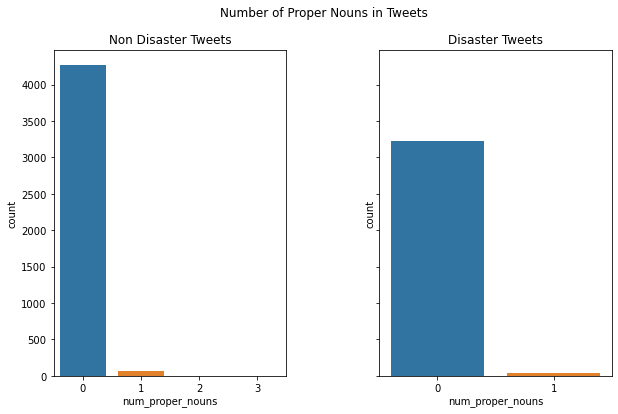

In [80]:
fig, ax = plt.subplots(1,2, figsize=(10,6), sharey=True)
fig.suptitle('Number of Proper Nouns in Tweets')
sns.countplot(x=tweets[tweets['target']==0]['num_proper_nouns'], data=tweets, ax=ax[0])
sns.countplot(x=tweets[tweets['target']==1]['num_proper_nouns'], data=tweets, ax=ax[1])
ax[0].set_title('Non Disaster Tweets')
ax[1].set_title('Disaster Tweets')
plt.subplots_adjust(wspace=0.4)
plt.savefig('Num_proper_nouns.png', bbox_inches = 'tight')
plt.show()

This is very similar in trend to mentions- that does make sense as the proper nouns might still be mentions 

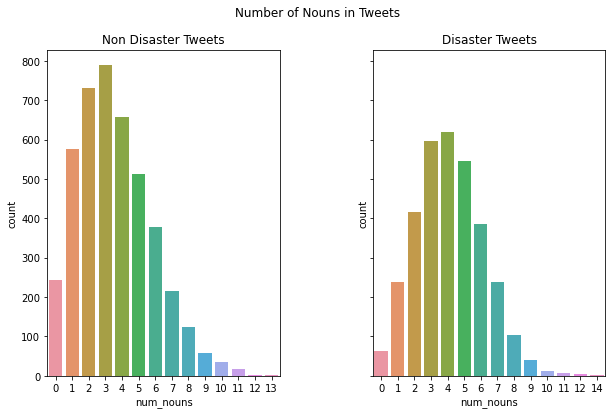

In [81]:
fig, ax = plt.subplots(1,2, figsize=(10,6), sharey=True)
fig.suptitle('Number of Nouns in Tweets')
sns.countplot(x=tweets[tweets['target']==0]['num_nouns'], data=tweets, ax=ax[0])
sns.countplot(x=tweets[tweets['target']==1]['num_nouns'], data=tweets, ax=ax[1])
ax[0].set_title('Non Disaster Tweets')
ax[1].set_title('Disaster Tweets')
plt.subplots_adjust(wspace=0.4)
plt.savefig('Num_nouns.png', bbox_inches = 'tight')
plt.show()

## 4. Basic Numerical Features - EDA

In [82]:
tweets.head()

text  target  num_hashtags  \
0                     deeds earthquake allah forgive       1             1   
1                             near ronge sask canada       1             0   
2  residents asked shelter notified officers shel...       1             0   
3                receive wildfires orders california       1             1   
4                   sent ruby alaska wildfires pours       1             2   

                hashtags  num_mentions mentions  emojis  num_chars  num_words  \
0          [#earthquake]             0       []       0         68         13   
1                     []             0       []       0         37          7   
2                     []             0       []       0        130         22   
3           [#wildfires]             0       []       0         56          7   
4  [#Alaska, #wildfires]             0       []       0         85         16   

   mean_word_length  num_proper_nouns  num_nouns  
0          4.307692                 0          2  
1          4.428571                 0          3  
2          4.954545                 0          5  
3          7.142857                 0          2  
4          4.375000                 0          3

In [83]:
tweets.columns

Index(['text', 'target', 'num_hashtags', 'hashtags', 'num_mentions',
       'mentions', 'emojis', 'num_chars', 'num_words', 'mean_word_length',
       'num_proper_nouns', 'num_nouns'],
      dtype='object')

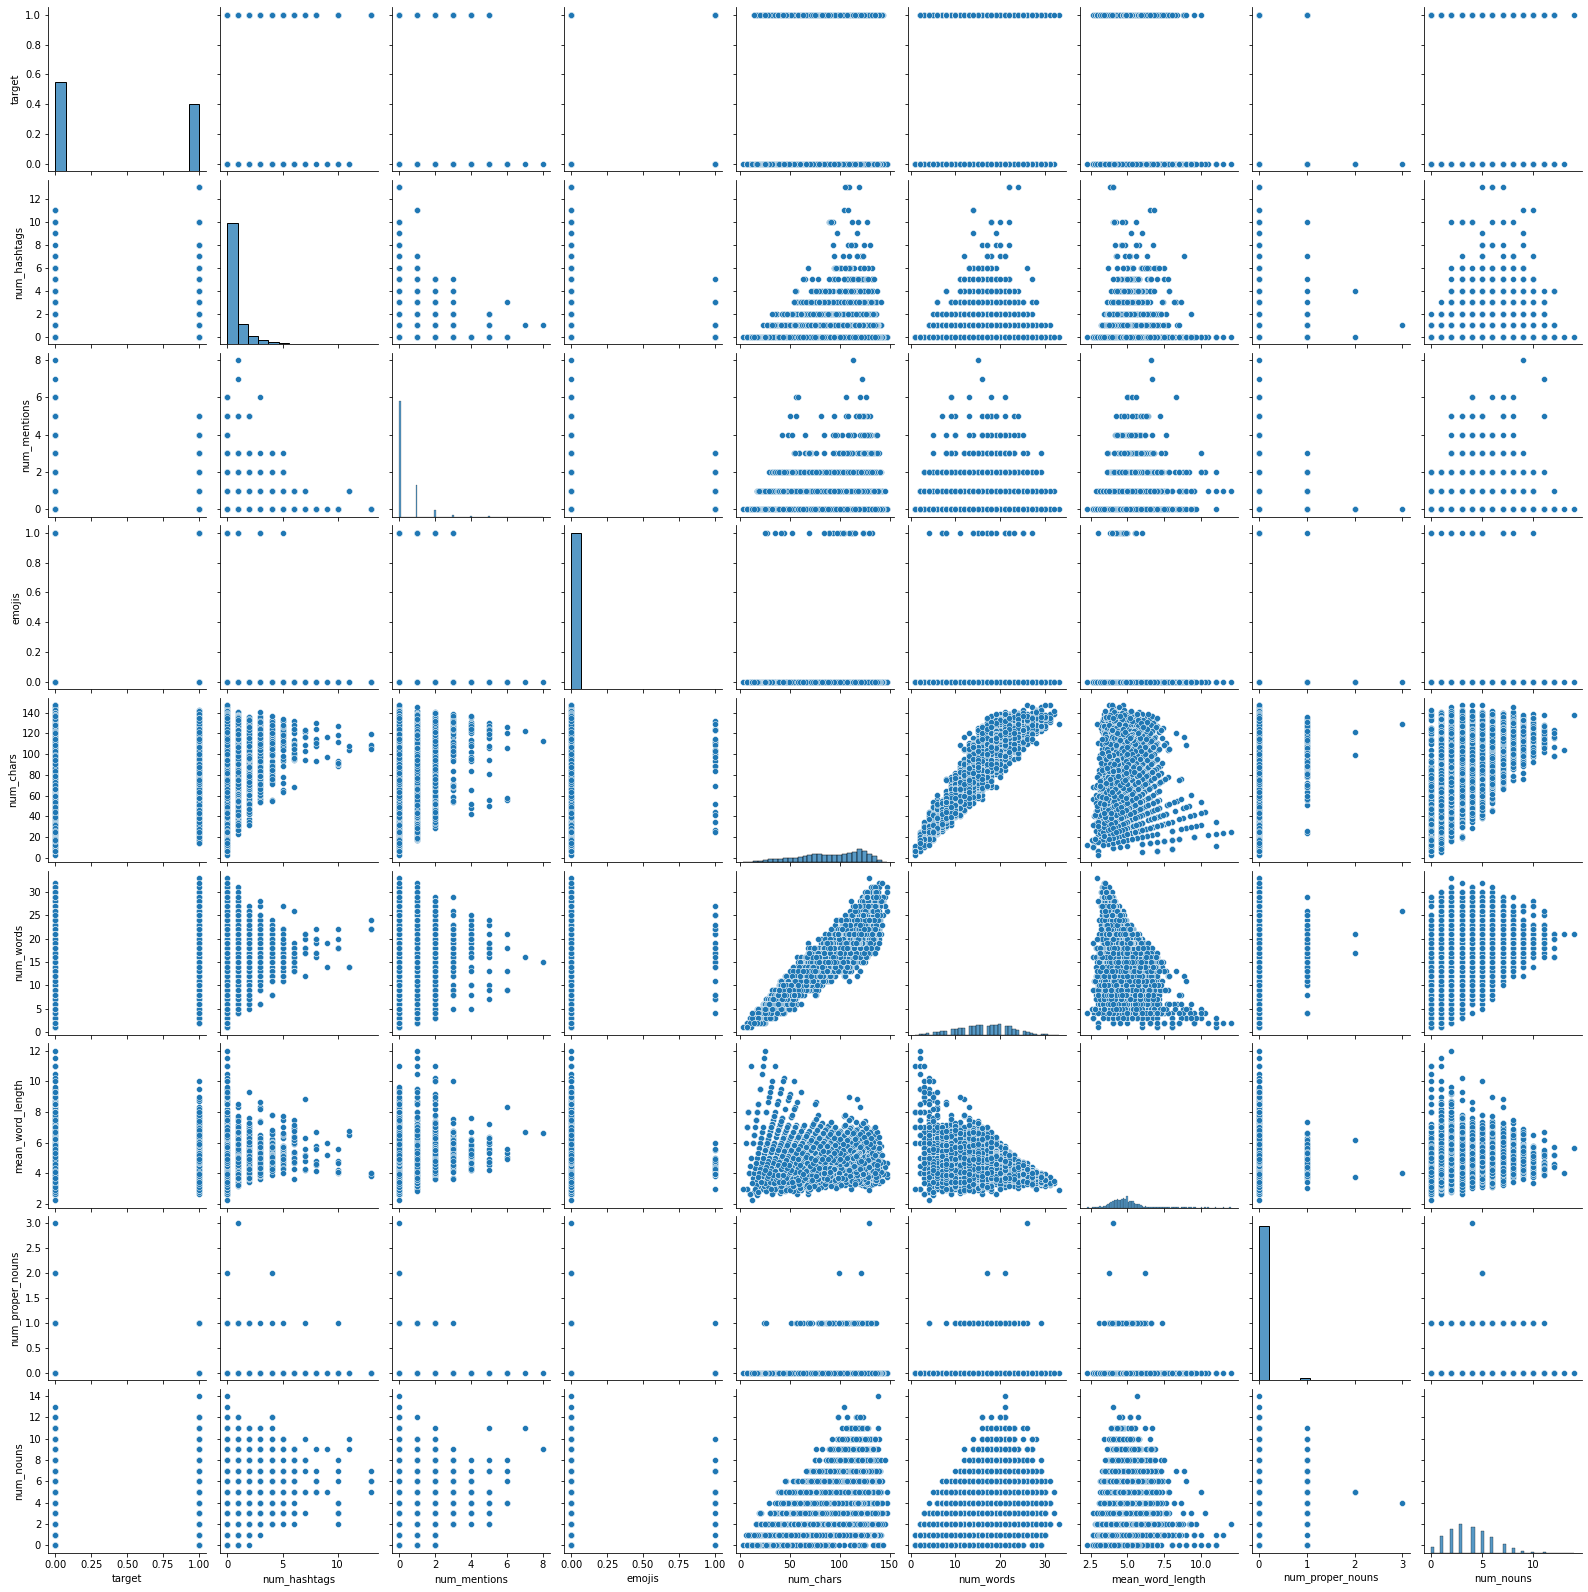

In [84]:
sns.pairplot(tweets)

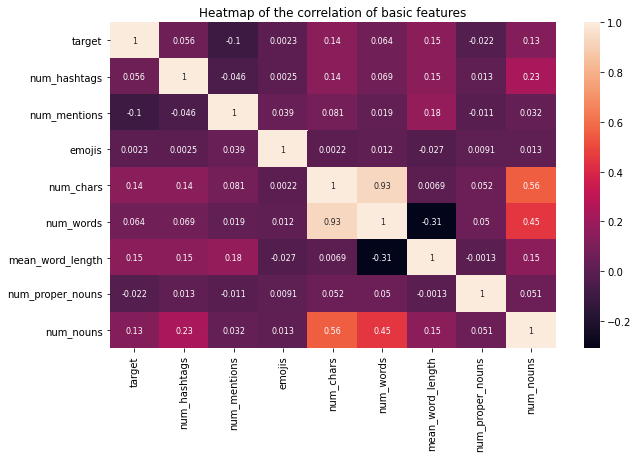

In [85]:
_ = plt.figure(figsize = (10,6))
_ = sns.heatmap(tweets.corr(), annot=True, annot_kws={"fontsize":8})
_ = plt.title('Heatmap of the correlation of basic features')
_ = plt.savefig('heatmap_correlation.png', bbox_inches = 'tight')
plt.show()

In [87]:
fig = px.box(tweets.drop(['text', 'hashtags', 'mentions'],axis=1), color = 'target')
fig.update_layout(xaxis_title = 'Features', yaxis_title = 'value')
fig.write_image('boxplot.png')
fig.show()


#### Conclusion

We can see that number of words in a tweet and the number of characters have a strong correlation, but that goes without saying really. Furthermore, we can see from the boxplot there aren't any significant outliers (taking outliers as values that like outside 1.5 x the interquartile ranges.

This highlights that we can't really see any important features that can help classify our tweets into the two clases. As a result, for our next stages we will drop these numerical features and just focus on the tweets itself to see if we can build a ML model and a Deep Leanring model for the binary classificaiton. 



## 5. Tokenizing and Lemmetizing Text

Before we can move onto the building out model, we need to make our tweets ready. This mean we need to somehow change our texts into numerical values as ML and Deep learning models don't take in non-numerical inputs. 

Our first step is to tokenize the tweets. This is to break up our sentences into individual words. From this, we can either lemmatize our tokens or stem them. I'm going to use the TweetTokenizer to tokensize our tweets, and then the WordNetLemmatizer to lemmatize the tokens. 

In [88]:
tweet_tokenizer = TweetTokenizer()
tweets['tokens'] = tweets['text'].apply(tweet_tokenizer.tokenize)
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    return [lemmatizer.lemmatize(w) for w in text]
tweets['lemmas'] = tweets.tokens.apply(lemmatize)

In [89]:
tweets.head()

text  target  num_hashtags  \
0                     deeds earthquake allah forgive       1             1   
1                             near ronge sask canada       1             0   
2  residents asked shelter notified officers shel...       1             0   
3                receive wildfires orders california       1             1   
4                   sent ruby alaska wildfires pours       1             2   

                hashtags  num_mentions mentions  emojis  num_chars  num_words  \
0          [#earthquake]             0       []       0         68         13   
1                     []             0       []       0         37          7   
2                     []             0       []       0        130         22   
3           [#wildfires]             0       []       0         56          7   
4  [#Alaska, #wildfires]             0       []       0         85         16   

   mean_word_length  num_proper_nouns  num_nouns  \
0          4.307692                 0          2   
1          4.428571                 0          3   
2          4.954545                 0          5   
3          7.142857                 0          2   
4          4.375000                 0          3   

                                              tokens  \
0                [deeds, earthquake, allah, forgive]   
1                        [near, ronge, sask, canada]   
2  [residents, asked, shelter, notified, officers...   
3           [receive, wildfires, orders, california]   
4             [sent, ruby, alaska, wildfires, pours]   

                                              lemmas  
0                 [deed, earthquake, allah, forgive]  
1                        [near, ronge, sask, canada]  
2  [resident, asked, shelter, notified, officer, ...  
3             [receive, wildfire, order, california]  
4              [sent, ruby, alaska, wildfire, pours]

## 6. Saving data 

In [90]:
tweets.to_csv('tweets.csv')